# [sec 0-0] import data 

In [ ]:
import numpy as np

In [ ]:
frames=np.load("../../../whimh2.0/outfile_x.npy")
y_train=np.load("../../../whimh2.0/outfile_y.npy").astype(int)

In [ ]:
print (y_train==0).sum() 
print (y_train==1).sum()
print (y_train==2).sum()
print (y_train==3).sum()
print (y_train==4).sum()

In [ ]:
frames[np.where(y_train==1)].shape

In [ ]:
arrMH=np.where(y_train==0)[0]
arrNM=np.where(y_train==1)[0]
arrNH=np.where(y_train==2)[0]
arrME=np.where(y_train==3)[0]
arrSO=np.where(y_train==4)[0]

max_=len(arrNM)
indx=np.random.randint(max_, size=1000)

newarr=np.concatenate((arrMH,arrNM[indx],arrNH,arrME,arrSO))

In [ ]:
# print images shapes
print newarr.shape

In [ ]:
frames=frames[newarr]
y_train=y_train[newarr]

# [sec 0-1]  vgg16 forward

In [ ]:
import tensorflow as tf

In [ ]:
#The only difference with a regular Session is that an InteractiveSession installs itself as the default session 
sess = tf.InteractiveSession()

#load the graph_def from disk
with open("../../../whimh2.0/vggface16.tfmodel", mode='rb') as f:
    fileContent = f.read()
graph_def = tf.GraphDef()
graph_def.ParseFromString(fileContent)

In [ ]:
# import the vgg 
x_tf = tf.placeholder(tf.float32, shape=[None, 32,32,3],name='imput_image')
x_tf_1=tf.image.resize_images(x_tf,[224,224])
y_tf = tf.placeholder(tf.int32, shape=[None,],name='ground_truth')
tf.import_graph_def(graph_def, input_map={ "images": x_tf_1 })
print "graph loaded into default graph"

graph = tf.get_default_graph()

In [ ]:
feature_net=graph.get_tensor_by_name("import/pool5:0")
feature_x1 = sess.run([feature_net], feed_dict={x_tf:frames[:100], y_tf: y_train[:100]})[0]
print feature_x1.shape

# [sec 0-2]  train a classifier first , cnn without rotate,stn ~0.97

In [ ]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.0001)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.01, shape=shape)
  return tf.Variable(initial)


In [ ]:
keep_prob = tf.placeholder(tf.float32,name='KP')
regular_lambda = tf.placeholder(tf.float32,name='RL')
learning_rate = tf.placeholder(tf.float32,name='LR')
with tf.name_scope('fintune_whimh'):
    with tf.name_scope('finetune_layer'):
        #calculate_entropy
        #h_pool3_flat = tf.reshape(x_tfed, [-1, 2*2*512])
        h_pool3_flat = tf.reshape(feature_net, [-1, 7*7*512])

        W_whimh_fc1 = weight_variable([7*7*512,1024])
        #W_whimh_fc1 = weight_variable([2*2*512, 1024])
        b_whimh_fc1 = bias_variable([1024])
        h_fc1=tf.nn.relu(tf.matmul(h_pool3_flat, W_whimh_fc1) + b_whimh_fc1) 
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob,name='keep_prob')

        tf.summary.histogram('fc_1/weights', W_whimh_fc1)
    with tf.name_scope('finetune_layer'):
        #calculate_entropy
        W_whimh_fc2 = weight_variable([1024, 5])
        b_whimh_fc2 = bias_variable([5])
        y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_whimh_fc2) + b_whimh_fc2, name='predictions_softmax') 
        tf.summary.histogram('fc_2/weights', W_whimh_fc2)
    y_tf_2=tf.one_hot(y_tf,5)
    with tf.name_scope('loss_calulate'):
        #calculate_entropy
        cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_tf_2 * tf.log(y_conv), reduction_indices=[1]))
    with tf.name_scope('regular'):    
        regularizers = (tf.nn.l2_loss(W_whimh_fc1) + tf.nn.l2_loss(b_whimh_fc1)+
                        (tf.nn.l2_loss(W_whimh_fc2) + tf.nn.l2_loss(b_whimh_fc2))
                       )

    with tf.name_scope('loss'):
        #carefully deal overfitting
        loss=cross_entropy+regular_lambda*regularizers
    with tf.name_scope('slover'):
        global_step = tf.Variable(0, trainable=False)
        learning_rate_decay = tf.train.exponential_decay(learning_rate, global_step,
                                                   1000, 0.96, staircase=True)
    # %% Define loss/eval/training functions
        opt = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_step = opt.minimize(loss)

    with tf.name_scope('measure'):
        with tf.name_scope('predict'):
            predctions=tf.argmax(y_conv,1, name='predictions_')
        with tf.name_scope('groundtruth'):
            ground_truth=tf.argmax(y_tf_2,1)
        correct_prediction = tf.equal(predctions, ground_truth)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
arr = np.arange(len(frames))
np.random.shuffle(arr)
x_train=frames[arr]
y_train=y_train[arr]
data={
  'X_train': x_train[:int(len(x_train)*0.8)],
  'y_train': y_train[:int(len(x_train)*0.8)],
  'X_val': x_train[int(len(x_train)*0.8):],
  'y_val': y_train[int(len(x_train)*0.8):],
  'X_val_frame' : frames[int(len(x_train)*0.8):],
}
print "there are "+ str(data['X_train'].shape[0]) + " images in training set"
print "there are "+ str(data['X_val'].shape[0]) + " images in testing set"

In [ ]:
sess.run(tf.global_variables_initializer())

In [ ]:
k=0
for i in range(3000):
  arr=np.arange(len(data['X_train']))
  np.random.shuffle(arr)
  idx = arr[:5]
  train_step.run(feed_dict={x_tf:data['X_train'][idx], y_tf: data['y_train'][idx],
                            keep_prob:0.5,
                            regular_lambda:0.001,
                            learning_rate:1e-6
                           })
  if i%200==0:
    ############training acc###########
    #train_accuracy = accuracy.eval(feed_dict={   
    #x_tf:data['X_train'], y_tf: data['y_train'], keep_prob: 1.0})
    arr=np.arange(len(data['X_train']))
    np.random.shuffle(arr)
    idx_train = arr[:100]
    train_accuracy,train_cross_entropy = sess.run([accuracy,cross_entropy], feed_dict={   
            x_tf:data['X_train'][idx_train], y_tf: data['y_train'][idx_train],
            keep_prob:1,
            regular_lambda:0.001,
            learning_rate:1e-6
        })
    #print train_accuracy
    ############testing acc#########
    arr=np.arange(len(data['X_val']))
    np.random.shuffle(arr)
    idx_test = arr[:100]
    testing_accuracy,test_cross_entropy = sess.run([accuracy,cross_entropy], feed_dict={   
            x_tf:data['X_val'][idx_test], y_tf: data['y_val'][idx_test],
            keep_prob:1,
            regular_lambda:0.001,
            learning_rate:1e-6})
    print("step %d, training accuracy %g, testing acc %g"%(i, train_accuracy,testing_accuracy))
    


In [ ]:
train_writer = tf.summary.FileWriter('/tmp/loser1/train',sess.graph)

In [ ]:
! ls

In [ ]:
saver = tf.train.Saver()
saver.save(sess, 'chkpt', global_step=0, latest_filename='chkpt_state')
tf.train.write_graph(sess.graph.as_graph_def(),"/home/stream/Documents/Rotation_Whimh/models/transformer", 'pretensorWhimh.pb', False)

In [ ]:
# freeze the graph
from freeze_graph import freeze_graph 
input_saver_def_path = ''
input_binary=True
input_checkpoint_path = './chkpt-0'
input_graph_path = 'pretensorWhimh.pb'
output_graph_path = 'pretensorWhimh.pb'
output_node_names = 'fintune_whimh/measure/predict/predictions_'
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
clear_devices = True

freeze_graph(input_graph_path, input_saver_def_path,
                              input_binary, input_checkpoint_path,
                              output_node_names, restore_op_name,
                              filename_tensor_name, output_graph_path,
                              clear_devices, "")

it seems can reach high accuracy easily , 
# [sec0-3] let's rotate~~!! cnn without stn ~0.93

In [ ]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [ ]:
data['X_val'][0].shape

In [ ]:

img=data['X_val'][0].astype(np.uint8)
plt.imshow(img)


In [ ]:
def getrotation_img(image,angel):
    rows,cols,c = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angel,1)
    dst = cv2.warpAffine(image,M,(cols,rows))
    return dst


In [ ]:
# rotation!!!
plt.imshow(getrotation_img(img,45))
print getrotation_img(img,45).shape

In [ ]:
import random
def rotation_all(X_train,angle):
    for i in xrange(X_train.shape[0]):
        angle+=random.randint(-22 ,22)
        if i==0:
            X_train_temp=np.reshape(getrotation_img(X_train[i],angle),[-1,32,32,3])
        else:
            temp=np.reshape(getrotation_img(X_train[i],angle),[-1,32,32,3])
            X_train_temp=np.concatenate((X_train_temp, temp), axis=0)
    print "the rotation output : "+str(X_train_temp.shape)
    return X_train_temp

In [ ]:
temp=rotation_all(frames,0)
#temp[0].shape
#plt.imshow(temp[30].astype(np.uint8))

In [ ]:
# training set
X_train=frames
X_train_0=rotation_all(frames,0)
X_train_0_1=rotation_all(frames,0)
X_train_45=rotation_all(frames,45)
X_train_45_1=rotation_all(frames,45)
X_train_90=rotation_all(frames,90)
X_train_90_1=rotation_all(frames,90)
X_train_135=rotation_all(frames,135)
X_train_135_1=rotation_all(frames,135)
X_train_180=rotation_all(frames,180)
X_train_180_1=rotation_all(frames,180)
X_train_180_2=rotation_all(frames,180)
X_train_225=rotation_all(frames,225)
X_train_225_1=rotation_all(frames,225)
X_train_270_1=rotation_all(frames,270)
X_train_270=rotation_all(frames,270)
X_train_315_1=rotation_all(frames,315)
X_train_315=rotation_all(frames,315)


In [ ]:
frames=np.concatenate((X_train,X_train_0,X_train_0_1,X_train_45,X_train_45_1,X_train_90,X_train_90_1,\
                       X_train_135,X_train_180,X_train_225,X_train_135_1,X_train_180_1,X_train_180_2
                       ,X_train_225_1,X_train_270,X_train_315,X_train_270_1,X_train_315_1),axis=0)
print frames.shape

y_train=np.concatenate((y_train,y_train,y_train,y_train,y_train,y_train,\
                        y_train,y_train,y_train,y_train,y_train,y_train,\
                       y_train,y_train,y_train,y_train,y_train,y_train),axis=0)
print y_train.shape

In [ ]:
np.save("rotated_x",frames)
np.save("rotated_y",y_train)


In [ ]:
!ls

In [ ]:
plt.imshow(frames[14500].astype(np.uint8))
y_train[14500]

In [ ]:
arr = np.arange(len(frames))
np.random.shuffle(arr)
x_train=frames[arr]
y_train=y_train[arr]
data={
  'X_train': x_train[:int(len(x_train)*0.8)],
  'y_train': y_train[:int(len(x_train)*0.8)],
  'X_val': x_train[int(len(x_train)*0.8):],
  'y_val': y_train[int(len(x_train)*0.8):],
  'X_val_frame' : frames[int(len(x_train)*0.8):],
}
print "there are "+ str(data['X_train'].shape[0]) + " images in training set"
print "there are "+ str(data['X_val'].shape[0]) + " images in testing set"

In [ ]:
# train the vgg model again

In [ ]:
sess.run(tf.global_variables_initializer())

In [ ]:
k=0
for i in range(10000):
  arr=np.arange(len(data['X_train']))
  np.random.shuffle(arr)
  idx = arr[:10]
  train_step.run(feed_dict={x_tf:data['X_train'][idx], y_tf: data['y_train'][idx],keep_prob:0.25})
  if i%200==0:
    ############training acc###########
    #train_accuracy = accuracy.eval(feed_dict={   
    #x_tf:data['X_train'], y_tf: data['y_train'], keep_prob: 1.0})
    idx_train=np.arange(len(data['X_train']))[:100]
    train_accuracy,train_cross_entropy = sess.run([accuracy,cross_entropy], feed_dict={   
            x_tf:data['X_train'][idx_train], y_tf: data['y_train'][idx_train],keep_prob:1})
    #print train_accuracy
    ############testing acc#########

    idx_test=np.arange(len(data['X_train']))[:100]
    testing_accuracy,test_cross_entropy = sess.run([accuracy,cross_entropy], feed_dict={   
            x_tf:data['X_val'][idx_test], y_tf: data['y_val'][idx_test],keep_prob:1})
    print("step %d, training accuracy %g, testing acc %g"%(i, train_accuracy,testing_accuracy))
    


# [sec 1-0] add a stn , rock it ~0.97 accuracy
issue 1 - stn almostly not updated - train with freezen graph
issue 2 - seems freezen kill the gradient??

In [ ]:
from spatial_transformer import transformer
import tensorflow as tf
import numpy as np
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.0001)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.01, shape=shape)
  return tf.Variable(initial)


In [ ]:
frames=np.load("rotated_x.npy")
y_train=np.load("rotated_y.npy").astype(int)

In [ ]:
arr = np.arange(len(frames))
np.random.shuffle(arr)
x_train=frames[arr]
y_train=y_train[arr]
data={
  'X_train': x_train[:int(len(x_train)*0.8)],
  'y_train': y_train[:int(len(x_train)*0.8)],
  'X_val': x_train[int(len(x_train)*0.8):],
  'y_val': y_train[int(len(x_train)*0.8):],
  'X_val_frame' : frames[int(len(x_train)*0.8):],
}
print "there are "+ str(data['X_train'].shape[0]) + " images in training set"
print "there are "+ str(data['X_val'].shape[0]) + " images in testing set"

In [ ]:
tf.reset_default_graph()

In [ ]:
def create_stn():
    # %% We can add dropout for regularizing and to reduce overfitting like so:
    keep_prob = tf.placeholder(tf.float32,name='KP')
    regular_lambda = tf.placeholder(tf.float32,name='RL')
    learning_rate = tf.placeholder(tf.float32,name='LR')

    # %% Placeholders for 40x40 resolution
    x = tf.placeholder(tf.float32, [None, 32,32,3])
    x_tensor = tf.image.resize_images(x,[40,40])

    filter_size = 3
    n_filters_1 = 32
    W_conv1_loc1 = weight_variable([filter_size, filter_size, 3, n_filters_1])
    b_conv1_loc1 = bias_variable([n_filters_1])

    W_fc_loc1 = weight_variable([1600, 20])
    b_fc_loc1 = bias_variable([20])

    #STN-conv_1-relu
    h_conv1_loc1 = tf.nn.relu(
        tf.nn.conv2d(input=x_tensor,
                     filter=W_conv1_loc1,
                     strides=[1, 2, 2, 1],
                     padding='SAME') +
        b_conv1_loc1)
    h_conv1_loc1_drop = tf.nn.dropout(h_conv1_loc1, keep_prob)
    h_conv1_loc1_flat = tf.reshape(h_conv1_loc1_drop, [-1, 20* 20 * n_filters_1])


    #STN-FC-relu
    n_fc_local=256
    W_fc_loc1 = weight_variable([20* 20* n_filters_1, n_fc_local])
    b_fc_loc1 = bias_variable([n_fc_local])
    h_fc_loc1 = tf.nn.relu(tf.matmul(h_conv1_loc1_flat, W_fc_loc1) + b_fc_loc1)


    #STN-FC-tanh
    initial = np.array([[1., 0, 0], [0, 1., 0]])
    initial = initial.astype('float32')
    initial = initial.flatten()
    b_fc_loc2 = tf.Variable(initial_value=initial, name='b_fc_loc2')
    W_fc_loc2 = weight_variable([n_fc_local, 6])

    h_fc_loc2 = tf.nn.tanh(tf.matmul(h_fc_loc1, W_fc_loc2) + b_fc_loc2)


    # %% We'll create a spatial transformer module to identify discriminative
    # %% patches
    out_size = (32, 32)
    h_trans = transformer(x_tensor, h_fc_loc2, out_size)

    regu_stn=tf.nn.l2_loss(b_fc_loc2)+tf.nn.l2_loss(W_fc_loc2)+\
            tf.nn.l2_loss(W_fc_loc1)+tf.nn.l2_loss(b_fc_loc1)+\
            tf.nn.l2_loss(W_conv1_loc1)+tf.nn.l2_loss(b_conv1_loc1)
    return [x,h_trans,regu_stn,h_fc_loc2,keep_prob,regular_lambda,learning_rate]



In [ ]:
x,h_trans,regu_stn,h_fc_loc2,keep_prob,regular_lambda,learning_rate = create_stn()

In [ ]:
#The only difference with a regular Session is that an InteractiveSession installs itself as the default session 
sess = tf.InteractiveSession()

#load the graph_def from disk
with open("../../../whimh2.0/vggface16.tfmodel", mode='rb') as f:
  fileContent = f.read()
graph_def = tf.GraphDef()
graph_def.ParseFromString(fileContent)

In [ ]:
# import the vgg 
#x_tf = tf.placeholder(tf.float32, shape=[None, 32,32,3])
x_tf_1=tf.image.resize_images(h_trans,[224,224])
y_tf = tf.placeholder(tf.int32, shape=[None,])
tf.import_graph_def(graph_def, input_map={ "images": x_tf_1 })
print "graph loaded into default graph"

graph = tf.get_default_graph()

In [ ]:
feature_net=graph.get_tensor_by_name("import/pool5:0")

In [ ]:
with tf.name_scope('fintune_whimh'):
    with tf.name_scope('finetune_layer'):
        #calculate_entropy
        h_pool3_flat = tf.reshape(feature_net, [-1, 7*7*512])

        W_whimh_fc1 = weight_variable([7*7*512,1024])
        #W_whimh_fc1 = weight_variable([2*2*512, 1024])
        b_whimh_fc1 = bias_variable([1024])
        h_fc1=tf.nn.relu(tf.matmul(h_pool3_flat, W_whimh_fc1) + b_whimh_fc1) 
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob,name='keep_prob')

        tf.summary.histogram('fc_1/weights', W_whimh_fc1)
    with tf.name_scope('finetune_layer'):
        #calculate_entropy
        W_whimh_fc2 = weight_variable([1024, 5])
        b_whimh_fc2 = bias_variable([5])
        y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_whimh_fc2) + b_whimh_fc2, name='predictions_softmax') 
        tf.summary.histogram('fc_2/weights', W_whimh_fc2)
    y_tf_2=tf.one_hot(y_tf,5)
    with tf.name_scope('loss_calulate'):
        #calculate_entropy
        cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_tf_2 * tf.log(y_conv), reduction_indices=[1]))
    with tf.name_scope('regular'):    
        regularizers = (tf.nn.l2_loss(W_whimh_fc1) + tf.nn.l2_loss(b_whimh_fc1)+
                        (tf.nn.l2_loss(W_whimh_fc2) + tf.nn.l2_loss(b_whimh_fc2))
                       )+regu_stn

    with tf.name_scope('loss'):
        #carefully deal overfitting
        loss=cross_entropy+regular_lambda*regularizers
    with tf.name_scope('slover'):
        global_step = tf.Variable(0, trainable=False)
        learning_rate_decay = tf.train.exponential_decay(learning_rate, global_step,
                                                   1000, 0.96, staircase=True)

    # %% Define loss/eval/training functions
        opt = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_step = opt.minimize(loss)

    with tf.name_scope('measure'):
        with tf.name_scope('predict'):
            predctions=tf.argmax(y_conv,1, name='predictions_')
        with tf.name_scope('groundtruth'):
            ground_truth=tf.argmax(y_tf_2,1)
        correct_prediction = tf.equal(predctions, ground_truth)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
sess.run(tf.global_variables_initializer())

In [ ]:
for i in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES):
    print sess.run(i).shape

In [ ]:
w=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)[0:3]
conv_w_init=sess.run(w[0])
bais_w_init=sess.run(w[1])
fc_w_init=sess.run(w[2])

In [ ]:
k=0
train_accuracy_sum=0
testing_accuracy_sum=0
for i in range(10000):
    arr=np.arange(len(data['X_train']))
    np.random.shuffle(arr)
    idx = arr[:10]
    train_step.run(feed_dict={x:data['X_train'][idx], y_tf: data['y_train'][idx],
                              keep_prob:1,
                              regular_lambda:0.001,
                              learning_rate:1e-6,
                             })
    if i%200==0:
        ############training acc###########
        for j in xrange(10):
            arr=np.arange(len(data['X_train']))
            np.random.shuffle(arr)
            idx_train = arr[:10]
            train_accuracy = sess.run(accuracy, feed_dict={   
                    x:data['X_train'][idx_train], y_tf: data['y_train'][idx_train],
                      keep_prob:1,
                      regular_lambda:0.0005,
                      learning_rate:0.001
                })
            train_accuracy_sum+=train_accuracy
        train_accuracy_sum/=10
        #print train_accuracy
        ############testing acc#########
        for j in xrange(10):
            arr=np.arange(len(data['X_val']))
            np.random.shuffle(arr)
            idx_test = arr[:10]
            testing_accuracy,test_cross_entropy = sess.run([accuracy,cross_entropy], feed_dict={   
                    x:data['X_val'][idx_test], y_tf: data['y_val'][idx_test],
                    keep_prob:1,
                    regular_lambda:0.001,
                    learning_rate:0.001
                })
            testing_accuracy_sum+=testing_accuracy
        testing_accuracy_sum/=10
        print("step %d, training accuracy %g, testing acc %g"%(i, train_accuracy_sum,testing_accuracy_sum))
        train_accuracy_sum=0
        testing_accuracy_sum=0
    


In [ ]:
w=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)[0:3]
conv_w_trained=sess.run(w[0])
bais_w_trained=sess.run(w[1])
fc_w_trained=sess.run(w[2])

In [ ]:
(conv_w_trained==conv_w_trained).all()

In [ ]:
ROI,theta = sess.run([h_trans,h_fc_loc2], feed_dict={
       x: data['X_train'][0:5], y_tf: data['y_val'][0:5], keep_prob: 1.0,
        regular_lambda:0.001,
        learning_rate:0.001})

print ROI.shape
print theta.shape

In [ ]:
def getboundary(theta):
    four_angles=np.array([[1,1,1],[1,-1,1],[-1,-1,1],[-1,1,1]])
    theta=theta.reshape([2,3])
    WH=np.array([40,40])
    return (((theta.dot(four_angles.T)+1)/2).T*WH)

In [ ]:
ROI[0].shape

In [ ]:
import cv2
count=1
for i in xrange(0,5):
    plt.subplot(5, 2, count)
    first_train_img = data['X_train'][i].copy().astype(np.uint8)
    fourangle=getboundary(theta[i])
    fourangle=fourangle.astype(int)
    #cv2.rectangle(first_train_img, tuple(twoangle[0].tolist()), tuple(twoangle[1].tolist()), (0, 1,0),2)
    cv2.line(first_train_img,tuple(fourangle[0].tolist()),tuple(fourangle[1].tolist()),(255,0,0),2)
    cv2.line(first_train_img,tuple(fourangle[1].tolist()),tuple(fourangle[2].tolist()),(0,255,0),2)
    cv2.line(first_train_img,tuple(fourangle[2].tolist()),tuple(fourangle[3].tolist()),(0,0,255),2)
    cv2.line(first_train_img,tuple(fourangle[3].tolist()),tuple(fourangle[0].tolist()),(0,255,0),2)
    plt.imshow(first_train_img)
    plt.axis('off')
    
    count+=1
    plt.subplot(5, 2, count)
    first_train_img = ROI[i].astype(np.uint8)
    plt.imshow(first_train_img, cmap = plt.get_cmap('gray'))
    plt.axis('off')
    count+=1

plt.show()

In [ ]:
# make it as function
def getrotation_img(image,angel):
    rows,cols,c = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angel,1)
    dst = cv2.warpAffine(image,M,(cols,rows))
    return dst


In [ ]:
test_idx=7000
print data['y_val'][test_idx]
det=getrotation_img(data['X_val'][test_idx, :],0)
plt.imshow(det.astype(np.uint8))

In [ ]:
# create 720 rotation images
print data['y_val'][test_idx]
temp_value=0
first=True
for i in xrange(720):
    if temp_value==0:
        X_test_temp=np.reshape(getrotation_img(data['X_val'][test_idx, :],i), (-1, 32,32,3))
        temp_value+=1
    else:
        temp=np.reshape(getrotation_img(data['X_val'][test_idx, :],i), (-1, 32,32,3))
        X_test_temp=np.concatenate((X_test_temp, temp), axis=0)
        temp_value+=1
        if i%10==9:

            ROI,theta,prediction = sess.run([h_trans,h_fc_loc2,predctions], feed_dict={
                   x: X_test_temp, keep_prob: 1.0})
            temp_value=0
            if first:
                ROI_sum=ROI
                theta_sum=theta
                prediction_sum=prediction
                first=False
            else:
                ROI_sum=np.concatenate((ROI_sum, ROI), axis=0)
                theta_sum=np.concatenate((theta_sum, theta), axis=0)
                prediction_sum=np.concatenate((prediction_sum, prediction), axis=0)

In [ ]:
ROI_sum.shape

In [ ]:
(prediction_sum==data['y_val'][test_idx]).mean()

In [ ]:
X_test_temp.shape

In [ ]:
count=1
for i in [15,30,90,180]:
    plt.subplot(5, 2, count)
    first_train_img = getrotation_img(data['X_val'][test_idx, :],i).copy().astype(np.uint8)
    fourangle=getboundary(theta_sum[i])
    fourangle=fourangle.astype(int)
    #cv2.rectangle(first_train_img, tuple(twoangle[0].tolist()), tuple(twoangle[1].tolist()), (0, 1,0),2)
    cv2.line(first_train_img,tuple(fourangle[0].tolist()),tuple(fourangle[1].tolist()),(255,0,0),2)
    cv2.line(first_train_img,tuple(fourangle[1].tolist()),tuple(fourangle[2].tolist()),(0,255,0),2)
    cv2.line(first_train_img,tuple(fourangle[2].tolist()),tuple(fourangle[3].tolist()),(0,0,255),2)
    cv2.line(first_train_img,tuple(fourangle[3].tolist()),tuple(fourangle[0].tolist()),(0,255,0),2)
    plt.imshow(first_train_img)
    plt.axis('off')
    
    count+=1
    plt.subplot(5, 2, count)
    first_train_img = ROI_sum[i].astype(np.uint8)
    plt.imshow(first_train_img)
    plt.axis('off')
    count+=1


plt.show()

In [ ]:
# add retangle to image and write it out
for i in xrange(720):
    first_train_img = getrotation_img(data['X_val'][test_idx, :],i).copy().astype(np.uint8)
    first_train_img = cv2.cvtColor(first_train_img,cv2.COLOR_BGR2RGB)
    fourangle=getboundary(theta_sum[i])
    fourangle=fourangle.astype(int)
    #cv2.rectangle(first_train_img, tuple(twoangle[0].tolist()), tuple(twoangle[1].tolist()), (0, 1,0),2)
    cv2.line(first_train_img,tuple(fourangle[0].tolist()),tuple(fourangle[1].tolist()),(255,0,0),2)
    cv2.line(first_train_img,tuple(fourangle[1].tolist()),tuple(fourangle[2].tolist()),(0,255,0),2)
    cv2.line(first_train_img,tuple(fourangle[2].tolist()),tuple(fourangle[3].tolist()),(0,0,255),2)
    cv2.line(first_train_img,tuple(fourangle[3].tolist()),tuple(fourangle[0].tolist()),(0,255,0),2)
    cv2.imwrite('face_rotation/'+str(i).zfill(4)+'.jpg',first_train_img)



# [sec 1-1] Stn almost not moving and rotaion,
## try a altertive way, train with a pretrained freezen model

In [ ]:
import tensorflow as tf
with open("pretensorWhimh.pb", mode='rb') as f:
    fileContent = f.read()

gdef_1 = tf.GraphDef()
gdef_1.ParseFromString(fileContent)

In [ ]:
[n.name for n in gdef_1.node ]
#'imput_image' ?x32x32x3
#'KP' float

In [ ]:
x_tf = tf.placeholder(tf.float32, shape=[None, 32,32,3],name='imput_image')
keep_prob = tf.placeholder(tf.float32,name='KP')


In [ ]:
prediction=tf.import_graph_def(gdef_1, input_map={"imput_image": x_tf ,'KP':keep_prob},return_elements=["fintune_whimh/measure/predict/predictions_:0"])

In [ ]:
import numpy as np
frames=np.load("../../../whimh2.0/outfile_x.npy")
y_train=np.load("../../../whimh2.0/outfile_y.npy").astype(int)

In [ ]:
import tensorflow as tf
sess = tf.InteractiveSession()

In [ ]:
results=sess.run(feature_x,feed_dict={x_tf:frames[700:800], keep_prob:1})

In [ ]:
# testing at the orginal data
sum(sum(results==y_train[700:800]))/100.0

In [ ]:
# testing at rotation data
frames=np.load("rotated_x.npy")
y_train=np.load("rotated_y.npy").astype(int)

In [ ]:
arr = np.arange(len(frames))
np.random.shuffle(arr)
x_train=frames[arr]
y_train=y_train[arr]
data={
  'X_train': x_train[:int(len(x_train)*0.8)],
  'y_train': y_train[:int(len(x_train)*0.8)],
  'X_val': x_train[int(len(x_train)*0.8):],
  'y_val': y_train[int(len(x_train)*0.8):],
  'X_val_frame' : frames[int(len(x_train)*0.8):],
}
print "there are "+ str(data['X_train'].shape[0]) + " images in training set"
print "there are "+ str(data['X_val'].shape[0]) + " images in testing set"

In [ ]:
results=sess.run(feature_x,feed_dict={x_tf:data['X_train'][700:800], keep_prob:1})

In [ ]:
# accuracy reduce to ~80%
sum(sum(results==data['y_train'][700:800]))/100.0

# let's attach stn!!


In [ ]:
import tensorflow as tf
from spatial_transformer import transformer
import numpy as np
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.0001)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.01, shape=shape)
  return tf.Variable(initial)


In [ ]:
tf.reset_default_graph()

In [ ]:

with open("pretensorWhimh.pb", mode='rb') as f:
    fileContent = f.read()

gdef_1 = tf.GraphDef()
gdef_1.ParseFromString(fileContent)

In [ ]:
def create_stn():
    # %% We can add dropout for regularizing and to reduce overfitting like so:
    keep_prob = tf.placeholder(tf.float32,name='KP')
    regular_lambda = tf.placeholder(tf.float32,name='RL')
    learning_rate = tf.placeholder(tf.float32,name='LR')

    # %% Placeholders for 40x40 resolution
    x = tf.placeholder(tf.float32, [None, 32,32,3])
    x_tensor = tf.image.resize_images(x,[40,40])

    filter_size = 3
    n_filters_1 = 32
    W_conv1_loc1 = weight_variable([filter_size, filter_size, 3, n_filters_1])
    b_conv1_loc1 = bias_variable([n_filters_1])

    W_fc_loc1 = weight_variable([1600, 20])
    b_fc_loc1 = bias_variable([20])

    #STN-conv_1-relu
    h_conv1_loc1 = tf.nn.relu(
        tf.nn.conv2d(input=x_tensor,
                     filter=W_conv1_loc1,
                     strides=[1, 2, 2, 1],
                     padding='SAME') +
        b_conv1_loc1)
    h_conv1_loc1_drop = tf.nn.dropout(h_conv1_loc1, keep_prob)
    h_conv1_loc1_flat = tf.reshape(h_conv1_loc1_drop, [-1, 20* 20 * n_filters_1])


    #STN-FC-relu
    n_fc_local=256
    W_fc_loc1 = weight_variable([20* 20* n_filters_1, n_fc_local])
    b_fc_loc1 = bias_variable([n_fc_local])
    h_fc_loc1 = tf.nn.relu(tf.matmul(h_conv1_loc1_flat, W_fc_loc1) + b_fc_loc1)


    #STN-FC-tanh
    initial = np.array([[1., 0, 0], [0, 1., 0]])
    initial = initial.astype('float32')
    initial = initial.flatten()
    b_fc_loc2 = tf.Variable(initial_value=initial, name='b_fc_loc2')
    W_fc_loc2 = weight_variable([n_fc_local, 6])

    h_fc_loc2 = tf.nn.tanh(tf.matmul(h_fc_loc1, W_fc_loc2) + b_fc_loc2)


    # %% We'll create a spatial transformer module to identify discriminative
    # %% patches
    out_size = (32, 32)
    h_trans = transformer(x_tensor, h_fc_loc2, out_size)

    regu_stn=tf.nn.l2_loss(b_fc_loc2)+tf.nn.l2_loss(W_fc_loc2)+\
            tf.nn.l2_loss(W_fc_loc1)+tf.nn.l2_loss(b_fc_loc1)+\
            tf.nn.l2_loss(W_conv1_loc1)+tf.nn.l2_loss(b_conv1_loc1)
    return [x,h_trans,regu_stn,h_fc_loc2,keep_prob,regular_lambda,learning_rate]



In [ ]:
x,h_trans,regu_stn,h_fc_loc2,keep_prob,regular_lambda,learning_rate = create_stn()

### attach!!

In [ ]:
prediction,predictions=tf.import_graph_def(gdef_1, input_map={"imput_image": h_trans ,'KP':keep_prob},
                        return_elements=["fintune_whimh/finetune_layer_1/predictions_softmax:0",
                                         "fintune_whimh/measure/predict/predictions_:0"])

### create loss function with prediction an regu_stn


In [ ]:
y_tf = tf.placeholder(tf.int32, shape=[None,],name='ground_truth')
y_tf_2=tf.one_hot(y_tf,5)
regular_lambda = tf.placeholder(tf.float32,name='RL')
learning_rate = tf.placeholder(tf.float32,name='LR')

In [ ]:
with tf.name_scope('loss_calulate'):
    #calculate_entropy
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_tf_2 * tf.log(prediction), reduction_indices=[1]))
with tf.name_scope('regular'):    
    regularizers = regu_stn

with tf.name_scope('loss'):
    #carefully deal overfitting
    loss=cross_entropy+regular_lambda*regularizers
with tf.name_scope('slover'):
    global_step = tf.Variable(0, trainable=False)
    learning_rate_decay = tf.train.exponential_decay(learning_rate, global_step,
                                               1000, 0.96, staircase=True)
    opt = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_step = opt.minimize(loss)

with tf.name_scope('measure'):
    with tf.name_scope('groundtruth'):
        ground_truth=tf.argmax(y_tf_2,1)
    correct_prediction = tf.equal(predictions, ground_truth)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
predictions

### prepare data

In [ ]:
# testing at rotation data
frames=np.load("rotated_x.npy")
y_train=np.load("rotated_y.npy").astype(int)

In [ ]:
arr = np.arange(len(frames))
np.random.shuffle(arr)
x_train=frames[arr]
y_train=y_train[arr]
data={
  'X_train': x_train[:int(len(x_train)*0.8)],
  'y_train': y_train[:int(len(x_train)*0.8)],
  'X_val': x_train[int(len(x_train)*0.8):],
  'y_val': y_train[int(len(x_train)*0.8):],
  'X_val_frame' : frames[int(len(x_train)*0.8):],
}
print "there are "+ str(data['X_train'].shape[0]) + " images in training set"
print "there are "+ str(data['X_val'].shape[0]) + " images in testing set"

In [ ]:
sess = tf.InteractiveSession()

In [ ]:
sess.run(tf.global_variables_initializer())

In [ ]:
k=0
train_accuracy_sum=0
testing_accuracy_sum=0
for i in range(10000):
    arr=np.arange(len(data['X_train']))
    np.random.shuffle(arr)
    idx = arr[:10]
    train_step.run(feed_dict={x:data['X_train'][idx], y_tf: data['y_train'][idx],
                              keep_prob:1,
                              regular_lambda:0,
                              learning_rate:1,
                             })
    if i%200==0:
        ############training acc###########
        for j in xrange(10):
            arr=np.arange(len(data['X_train']))
            np.random.shuffle(arr)
            idx_train = arr[:10]
            train_accuracy = sess.run(accuracy, feed_dict={   
                    x:data['X_train'][idx_train], y_tf: data['y_train'][idx_train],
                      keep_prob:1,
                      regular_lambda:0.0005,
                      learning_rate:0.001
                })
            train_accuracy_sum+=train_accuracy
        train_accuracy_sum/=10
        #print train_accuracy
        ############testing acc#########
        for j in xrange(10):
            arr=np.arange(len(data['X_val']))
            np.random.shuffle(arr)
            idx_test = arr[:10]
            testing_accuracy,test_cross_entropy = sess.run([accuracy,cross_entropy], feed_dict={   
                    x:data['X_val'][idx_test], y_tf: data['y_val'][idx_test],
                    keep_prob:1,
                    regular_lambda:0.001,
                    learning_rate:0.001
                })
            testing_accuracy_sum+=testing_accuracy
        testing_accuracy_sum/=10
        print("step %d, training accuracy %g, testing acc %g"%(i, train_accuracy_sum,testing_accuracy_sum))
        train_accuracy_sum=0
        testing_accuracy_sum=0
    

# sec [1-2] add stn at pooling 5
fucking wondering if it's wrong with freezen model

In [ ]:
import tensorflow as tf
from spatial_transformer import transformer
import numpy as np
frames=np.load("rotated_x.npy")
y_train=np.load("rotated_y.npy").astype(int)

In [ ]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.0001)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.01, shape=shape)
  return tf.Variable(initial)


In [ ]:
#load the graph_def from disk
with open("../../../whimh2.0/vggface16.tfmodel", mode='rb') as f:
    fileContent = f.read()
graph_def = tf.GraphDef()
graph_def.ParseFromString(fileContent)

In [ ]:
tf.reset_default_graph()

In [ ]:
x_tf = tf.placeholder(tf.float32, shape=[None, 32,32,3])
x_tf_1=tf.image.resize_images(x_tf,[224,224])
tf.import_graph_def(graph_def, input_map={ "images": x_tf_1 })
print "graph loaded into default graph"

In [ ]:
feature_net=graph.get_tensor_by_name("import/pool5:0")

In [ ]:
sess = tf.InteractiveSession()

In [ ]:
for i in xrange(frames.shape[0]/100):
    if i==0:
        feature_x = sess.run([feature_net], feed_dict={x_tf:frames[:100]})[0]
    elif i==frames.shape[0]/100:
        feature_x1 = sess.run([feature_net], feed_dict={x_tf:frames[i*100:]})[0]
    else:
        feature_x1 = sess.run([feature_net], feed_dict={x_tf:frames[i*100:(i+1)*100]})[0]
    if i!=0:
        feature_x=np.concatenate((feature_x,feature_x1))

In [ ]:
np.save("rotated_x_pool5",feature_x)

In [ ]:
feature_x.shape

# let's attach the stn to pooling5


In [ ]:
import tensorflow as tf
from spatial_transformer import transformer
import numpy as np
frames=np.load("rotated_x.npy")
y_train=np.load("rotated_y.npy").astype(int)
feature_x=np.load("rotated_x_pool5.npy")


In [ ]:
print frames.shape
print y_train.shape
print feature_x.shape

In [ ]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.0001)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.01, shape=shape)
  return tf.Variable(initial)


In [ ]:
def create_stn():
    # %% We can add dropout for regularizing and to reduce overfitting like so:
    keep_prob = tf.placeholder(tf.float32,name='KP')
    regular_lambda = tf.placeholder(tf.float32,name='RL')
    learning_rate = tf.placeholder(tf.float32,name='LR')

    # %% Placeholders for 40x40 resolution
    x_tensor = tf.placeholder(tf.float32, [None, 7,7,512])

    filter_size = 3
    n_filters_1 = 32
    W_conv1_loc1 = weight_variable([filter_size, filter_size, 512, n_filters_1])
    b_conv1_loc1 = bias_variable([n_filters_1])

    #STN-conv_1-relu
    h_conv1_loc1 = tf.nn.relu(
        tf.nn.conv2d(input=x_tensor,
                     filter=W_conv1_loc1,
                     strides=[1, 2, 2, 1],
                     padding='SAME') +
        b_conv1_loc1)
    
    h_conv1_loc1_drop = tf.nn.dropout(h_conv1_loc1, keep_prob)
    h_conv1_loc1_flat = tf.reshape(h_conv1_loc1_drop, [-1, 4* 4* n_filters_1])

    
    #STN-FC-relu
    n_fc_local=256
    W_fc_loc1 = weight_variable([ 4* 4* n_filters_1, n_fc_local])
    b_fc_loc1 = bias_variable([n_fc_local])
    h_fc_loc1 = tf.nn.relu(tf.matmul(h_conv1_loc1_flat, W_fc_loc1) + b_fc_loc1)


    #STN-FC-tanh
    initial = np.array([[1., 0, 0], [0, 1., 0]])
    initial = initial.astype('float32')
    initial = initial.flatten()
    b_fc_loc2 = tf.Variable(initial_value=initial, name='b_fc_loc2')
    W_fc_loc2 = weight_variable([n_fc_local, 6])

    h_fc_loc2 = tf.nn.tanh(tf.matmul(h_fc_loc1, W_fc_loc2) + b_fc_loc2)


    # %% We'll create a spatial transformer module to identify discriminative
    # %% patches
    out_size = (7, 7)
    h_trans = transformer(x_tensor, h_fc_loc2, out_size)

    regu_stn=tf.nn.l2_loss(b_fc_loc2)+tf.nn.l2_loss(W_fc_loc2)+\
            tf.nn.l2_loss(W_fc_loc1)+tf.nn.l2_loss(b_fc_loc1)+\
            tf.nn.l2_loss(W_conv1_loc1)+tf.nn.l2_loss(b_conv1_loc1)
    return [x_tensor,h_trans,regu_stn,h_fc_loc2,keep_prob,regular_lambda,learning_rate]


In [ ]:
tf.reset_default_graph()
sess = tf.InteractiveSession()


In [ ]:
x,h_trans,regu_stn,h_fc_loc2,keep_prob,regular_lambda,learning_rate = create_stn()
sess.run(tf.global_variables_initializer())
print sess.run([h_trans], feed_dict={x:feature_x[:1],keep_prob:1})[0].shape

In [ ]:
y_tf = tf.placeholder(tf.int32, shape=[None,],name='ground_truth')


In [ ]:
with tf.name_scope('fintune_whimh'):
    with tf.name_scope('finetune_layer'):
        #calculate_entropy
        h_pool3_flat = tf.reshape(h_trans, [-1, 7*7*512])
        W_whimh_fc1 = weight_variable([7*7*512,512])
        #W_whimh_fc1 = weight_variable([2*2*512, 1024])
        b_whimh_fc1 = bias_variable([512])
        h_fc1=tf.nn.relu(tf.matmul(h_pool3_flat, W_whimh_fc1) + b_whimh_fc1) 
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob,name='keep_prob')

    with tf.name_scope('finetune_layer'):
        #calculate_entropy
        W_whimh_fc2 = weight_variable([512, 5])
        b_whimh_fc2 = bias_variable([5])
        y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_whimh_fc2) + b_whimh_fc2, name='predictions_softmax') 
    y_tf_2=tf.one_hot(y_tf,5)
    with tf.name_scope('loss_calulate'):
        #calculate_entropy
        cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_tf_2 * tf.log(y_conv), reduction_indices=[1]))
    with tf.name_scope('regular'):    
        regularizers = (tf.nn.l2_loss(W_whimh_fc1) + tf.nn.l2_loss(b_whimh_fc1)+
                        (tf.nn.l2_loss(W_whimh_fc2) + tf.nn.l2_loss(b_whimh_fc2))
                       )+regu_stn

    with tf.name_scope('loss'):
        #carefully deal overfitting
        loss=cross_entropy+regular_lambda*regularizers
    with tf.name_scope('slover'):
        global_step = tf.Variable(0, trainable=False)
        learning_rate_decay = tf.train.exponential_decay(learning_rate, global_step,
                                                   1000, 0.96, staircase=True)

    # %% Define loss/eval/training functions
        opt = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_step = opt.minimize(loss)

    with tf.name_scope('measure'):
        with tf.name_scope('predict'):
            predctions=tf.argmax(y_conv,1, name='predictions_')
        with tf.name_scope('groundtruth'):
            ground_truth=tf.argmax(y_tf_2,1)
        correct_prediction = tf.equal(predctions, ground_truth)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
len(feature_x)

### let's go training training all night ohohoh

In [ ]:
arr = np.arange(len(feature_x))
np.random.shuffle(arr)
x_train=feature_x[arr]
y_train=y_train[arr]
data={
  'X_train': x_train[:int(len(x_train)*0.8)],
  'y_train': y_train[:int(len(x_train)*0.8)],
  'X_val': x_train[int(len(x_train)*0.8):],
  'y_val': y_train[int(len(x_train)*0.8):],
  'X_val_frame' : frames[int(len(x_train)*0.8):],
}
print "there are "+ str(data['X_train'].shape[0]) + " images in training set"
print "there are "+ str(data['X_val'].shape[0]) + " images in testing set"

In [ ]:
sess.run(tf.global_variables_initializer())

In [ ]:
k=0
for i in range(15000):
  arr=np.arange(len(data['X_train']))
  np.random.shuffle(arr)
  idx = arr[:15]
  train_step.run(feed_dict={x:data['X_train'][idx], y_tf: data['y_train'][idx],
                            keep_prob:1,
                            regular_lambda:0.0005,
                            learning_rate:1e-7
                           })
  if i%200==0:
    ############training acc###########
    #train_accuracy = accuracy.eval(feed_dict={   
    #x_tf:data['X_train'], y_tf: data['y_train'], keep_prob: 1.0})
    arr=np.arange(len(data['X_train']))
    np.random.shuffle(arr)
    idx_train = arr[:400]
    train_accuracy,train_cross_entropy = sess.run([accuracy,cross_entropy], feed_dict={   
            x:data['X_train'][idx_train], y_tf: data['y_train'][idx_train],
            keep_prob:1,
            regular_lambda:0.001,
            learning_rate:1e-6
        })
    #print train_accuracy
    ############testing acc#########
    arr=np.arange(len(data['X_val']))
    np.random.shuffle(arr)
    idx_test = arr[:400]
    testing_accuracy,test_cross_entropy = sess.run([accuracy,cross_entropy], feed_dict={   
            x:data['X_val'][idx_test], y_tf: data['y_val'][idx_test],
            keep_prob:1,
            regular_lambda:0.001,
            learning_rate:1e-6})
    print("step %d, training accuracy %g, testing acc %g"%(i, train_accuracy,testing_accuracy))
    


In [ ]:
# make it as function
import cv2
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
def getrotation_img(image,angel):
    rows,cols,c = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angel,1)
    dst = cv2.warpAffine(image,M,(cols,rows))
    return dst

In [ ]:
test_idx=99
print data['y_val'][test_idx]
det=getrotation_img(data['X_val_frame'][test_idx, :],0)
plt.imshow(det.astype(np.uint8))

In [ ]:

# create 720 rotation images
print data['y_val'][test_idx]
for i in xrange(720):
    if i==0:
        X_test_temp=np.reshape(getrotation_img(data['X_val_frame'][test_idx, :],i), (-1, 32,32,3))
    else:
        temp=np.reshape(getrotation_img(data['X_val_frame'][test_idx, :],i), (-1, 32,32,3))
        X_test_temp=np.concatenate((X_test_temp, temp), axis=0)


In [ ]:
#load the graph_def from disk
with open("../../../whimh2.0/vggface16.tfmodel", mode='rb') as f:
    fileContent = f.read()
graph_def = tf.GraphDef()
graph_def.ParseFromString(fileContent)

In [ ]:
x_tf = tf.placeholder(tf.float32, shape=[None, 32,32,3])
x_tf_1=tf.image.resize_images(x_tf,[224,224])
tf.import_graph_def(graph_def, input_map={ "images": x_tf_1 })
print "graph loaded into default graph"

In [ ]:
graph = tf.get_default_graph()
feature_net=graph.get_tensor_by_name("import/pool5:0")

In [ ]:
#forward to pooling5
whimh_poll_100 = sess.run([feature_net], feed_dict={
       x_tf: X_test_temp[:100], keep_prob: 1.0})
whimh_poll_200 = sess.run([feature_net], feed_dict={
       x_tf: X_test_temp[100:200], keep_prob: 1.0})
whimh_poll_300 = sess.run([feature_net], feed_dict={
       x_tf: X_test_temp[200:300], keep_prob: 1.0})
whimh_poll_400 = sess.run([feature_net], feed_dict={
       x_tf: X_test_temp[300:400], keep_prob: 1.0})
whimh_poll_500 = sess.run([feature_net], feed_dict={
       x_tf: X_test_temp[400:500], keep_prob: 1.0})
whimh_poll_600 = sess.run([feature_net], feed_dict={
       x_tf: X_test_temp[500:600], keep_prob: 1.0})
whimh_poll_700 = sess.run([feature_net], feed_dict={
       x_tf: X_test_temp[600:700], keep_prob: 1.0})
whimh_poll_800 = sess.run([feature_net], feed_dict={
       x_tf: X_test_temp[700:], keep_prob: 1.0})

In [ ]:
whimh_poll=(np.concatenate((whimh_poll_100[0],whimh_poll_200[0],whimh_poll_300[0],whimh_poll_400[0],
                           whimh_poll_500[0],whimh_poll_600[0],whimh_poll_700[0],whimh_poll_800[0]), axis=0))

In [ ]:
predctions_whimh,theta = sess.run([predctions,h_fc_loc2], feed_dict={   
        x:whimh_poll,
        keep_prob:1,
        regular_lambda:0.001,
        learning_rate:1e-6
    })


In [ ]:
print sum(predctions_whimh==0)/720.0

In [ ]:
def getboundary(theta):
    four_angles=np.array([[1,1,1],[1,-1,1],[-1,-1,1],[-1,1,1]])
    theta=theta.reshape([2,3])
    WH=np.array([32,32])
    return (((theta.dot(four_angles.T)+1)/2).T*WH)

In [ ]:
import cv2
count=1
for i in [15,30,90,180]:
    plt.subplot(5, 1, count)
    first_train_img = X_test_temp[i].copy()
    #first_train_img = cv2.cvtColor(first_train_img,cv2.COLOR_GRAY2RGB)
    fourangle=getboundary(theta[i])
    fourangle=fourangle.astype(int)
    cv2.line(first_train_img,tuple(fourangle[0].tolist()),tuple(fourangle[1].tolist()),(255,0,0),2)
    cv2.line(first_train_img,tuple(fourangle[1].tolist()),tuple(fourangle[2].tolist()),(0,255,0),2)
    cv2.line(first_train_img,tuple(fourangle[2].tolist()),tuple(fourangle[3].tolist()),(0,0,255),2)
    cv2.line(first_train_img,tuple(fourangle[3].tolist()),tuple(fourangle[0].tolist()),(0,255,0),2)
    plt.imshow(first_train_img.astype(np.uint8))
    plt.axis('off')
    count+=1

plt.show()

In [ ]:
# add retangle to image and write it out
for i in xrange(720):
    first_train_img = X_test_temp[i].copy().astype(np.uint8)
    first_train_img = cv2.cvtColor(first_train_img,cv2.COLOR_BGR2RGB)
    #first_train_img = cv2.cvtColor(first_train_img,cv2.COLOR_GRAY2RGB)
    fourangle=getboundary(theta[i])
    fourangle=fourangle.astype(int)
    #cv2.rectangle(first_train_img, tuple(twoangle[0].tolist()), tuple(twoangle[1].tolist()), (0, 1,0),2)
    cv2.line(first_train_img,tuple(fourangle[0].tolist()),tuple(fourangle[1].tolist()),(255,0,0),2)
    cv2.line(first_train_img,tuple(fourangle[1].tolist()),tuple(fourangle[2].tolist()),(0,255,0),2)
    cv2.line(first_train_img,tuple(fourangle[2].tolist()),tuple(fourangle[3].tolist()),(0,0,255),2)
    cv2.line(first_train_img,tuple(fourangle[3].tolist()),tuple(fourangle[0].tolist()),(0,255,0),2)
    cv2.imwrite('face_rotation/'+str(i).zfill(4)+'.jpg',first_train_img)

# [sec2-0] give up with pretrained vgg Acc~0.97
 let's deal a naive conv-relu *2 , fc softmax network

In [1]:
import tensorflow as tf
from spatial_transformer import transformer
import numpy as np
frames=np.load("rotated_x.npy")
y_train=np.load("rotated_y.npy").astype(int)


In [2]:
arr = np.arange(len(frames))
np.random.shuffle(arr)
x_train=frames[arr]
y_train=y_train[arr]
data={
  'X_train': x_train[:int(len(x_train)*0.8)],
  'y_train': y_train[:int(len(x_train)*0.8)],
  'X_val': x_train[int(len(x_train)*0.8):],
  'y_val': y_train[int(len(x_train)*0.8):],
  'X_val_frame' : frames[int(len(x_train)*0.8):],
}
print "there are "+ str(data['X_train'].shape[0]) + " images in training set"
print "there are "+ str(data['X_val'].shape[0]) + " images in testing set"

there are 32126 images in training set
there are 8032 images in testing set


In [3]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.0001)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.01, shape=shape)
  return tf.Variable(initial)


In [4]:
def create_stn():
    # %% We can add dropout for regularizing and to reduce overfitting like so:
    keep_prob = tf.placeholder(tf.float32,name='KP')
    regular_lambda = tf.placeholder(tf.float32,name='RL')
    learning_rate = tf.placeholder(tf.float32,name='LR')

    # %% Placeholders for 40x40 resolution
    x_tensor = tf.placeholder(tf.float32, [None, 32,32,3])

    filter_size = 3
    n_filters_1 = 32
    W_conv1_loc1 = weight_variable([filter_size, filter_size, 3, n_filters_1])
    b_conv1_loc1 = bias_variable([n_filters_1])

    #STN-conv_1-relu
    h_conv1_loc1 = tf.nn.relu(
        tf.nn.conv2d(input=x_tensor,
                     filter=W_conv1_loc1,
                     strides=[1, 2, 2, 1],
                     padding='SAME') +
        b_conv1_loc1)
    
    h_conv1_loc1_drop = tf.nn.dropout(h_conv1_loc1, keep_prob)
    h_conv1_loc1_flat = tf.reshape(h_conv1_loc1_drop, [-1, 16* 16* n_filters_1])

    
    #STN-FC-relu
    n_fc_local=256
    W_fc_loc1 = weight_variable([ 16* 16* n_filters_1, n_fc_local])
    b_fc_loc1 = bias_variable([n_fc_local])
    h_fc_loc1 = tf.nn.relu(tf.matmul(h_conv1_loc1_flat, W_fc_loc1) + b_fc_loc1)


    #STN-FC-tanh
    initial = np.array([[1., 0, 0], [0, 1., 0]])
    initial = initial.astype('float32')
    initial = initial.flatten()
    b_fc_loc2 = tf.Variable(initial_value=initial, name='b_fc_loc2')
    W_fc_loc2 = weight_variable([n_fc_local, 6])

    h_fc_loc2 = tf.nn.tanh(tf.matmul(h_fc_loc1, W_fc_loc2) + b_fc_loc2)


    # %% We'll create a spatial transformer module to identify discriminative
    # %% patches
    out_size = (32, 32)
    h_trans = transformer(x_tensor, h_fc_loc2, out_size)

    regu_stn=tf.nn.l2_loss(b_fc_loc2)+tf.nn.l2_loss(W_fc_loc2)+\
            tf.nn.l2_loss(W_fc_loc1)+tf.nn.l2_loss(b_fc_loc1)+\
            tf.nn.l2_loss(W_conv1_loc1)+tf.nn.l2_loss(b_conv1_loc1)
    return [x_tensor,h_trans,regu_stn,h_fc_loc2,keep_prob,regular_lambda,learning_rate]


In [5]:
x,h_trans,regu_stn,h_fc_loc2,keep_prob,regular_lambda,learning_rate = create_stn()


In [6]:

# %% We can add dropout for regularizing and to reduce overfitting like so:
regular_lambda = tf.placeholder(tf.float32)
learning_rate = tf.placeholder(tf.float32)


# %% Graph representation of our network

# %% Placeholders for 40x40 resolution
y_tf = tf.placeholder(tf.int32, shape=[None,],name='ground_truth')
y_tf_2=tf.one_hot(y_tf,5)

#reshape X
x_tensor = h_trans


#conv_1
filter_size = 3
n_filters_1 = 16
W_conv1 = weight_variable([filter_size, filter_size, 3, n_filters_1])
b_conv1 = bias_variable([n_filters_1])
h_conv1 = tf.nn.relu(
    tf.nn.conv2d(input=x_tensor,
                 filter=W_conv1,
                 strides=[1, 2, 2, 1],
                 padding='SAME') +
    b_conv1)
h_conv1_flat = tf.reshape(h_conv1, [-1, 16 * 16* n_filters_1])




#FC
n_fc = 512
W_fc1 = weight_variable([16 * 16 * n_filters_1, n_fc])
b_fc1 = bias_variable([n_fc])
h_fc1 = tf.nn.relu(tf.matmul(h_conv1_flat, W_fc1) + b_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#softmax
W_fc2 = weight_variable([n_fc, 5])
b_fc2 = bias_variable([5])
y_logits = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# regu_cnn = tf.nn.l2_loss(W_fc1)+tf.nn.l2_loss(W_fc2)+tf.nn.l2_loss(b_fc1)+tf.nn.l2_loss(b_fc2)+\
#        tf.nn.l2_loss(W_conv2)+tf.nn.l2_loss(W_conv1)+tf.nn.l2_loss(b_conv2)+tf.nn.l2_loss(b_conv1)
    
regu_cnn = tf.nn.l2_loss(W_fc1)+tf.nn.l2_loss(W_fc2)+tf.nn.l2_loss(b_fc1)+tf.nn.l2_loss(b_fc2)+\
    tf.nn.l2_loss(W_conv1)+tf.nn.l2_loss(b_conv1)
regu=regu_cnn+regu_stn


# global_step = tf.Variable(0, trainable=False)
# learning_rate_decay = tf.train.exponential_decay(learning_rate, global_step,
#                                            1000, 0.96, staircase=True)

# %% Define loss/eval/training functions
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=y_logits, labels=y_tf_2))

with tf.name_scope('loss'):
    #carefully deal overfitting
    loss=cross_entropy+regular_lambda*regu
with tf.name_scope('slover'):
    global_step = tf.Variable(0, trainable=False)
    learning_rate_decay = tf.train.exponential_decay(learning_rate, global_step,
                                               3000, 0.96, staircase=True)
    opt = tf.train.AdamOptimizer(learning_rate=learning_rate_decay)
    train_step = opt.minimize(loss)



#grads = opt.compute_gradients(cross_entropy, [b_fc_loc2])

# %% Monitor accuracy
tf_predictions=tf.argmax(y_logits, 1)
ground_truth=tf.argmax(y_tf_2, 1)
correct_prediction = tf.equal(tf.argmax(y_logits, 1), ground_truth)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

#MHaccuracy
idxsMH = tf.where(tf.equal(ground_truth, 0))
correct_predictionMH = tf.equal(tf.argmax(tf.gather(y_logits,idxsMH),2), tf.argmax(tf.gather(y_tf_2,idxsMH),2))
accuracyMH = tf.reduce_mean(tf.cast(correct_predictionMH, tf.float32))
#NMaccuracy
idxsNM = tf.where(tf.equal(ground_truth, 1))
correct_predictionNM = tf.equal(tf.argmax(tf.gather(y_logits,idxsNM),2), tf.argmax(tf.gather(y_tf_2,idxsNM),2))
accuracyNM = tf.reduce_mean(tf.cast(correct_predictionNM, tf.float32))
#NHaccuracy
idxsNH = tf.where(tf.equal(ground_truth, 2))
correct_predictionNH = tf.equal(tf.argmax(tf.gather(y_logits,idxsNH),2), tf.argmax(tf.gather(y_tf_2,idxsNH),2))
accuracyNH = tf.reduce_mean(tf.cast(correct_predictionNH, tf.float32))
#MEaccuracy
idxsME = tf.where(tf.equal(ground_truth, 3))
correct_predictionME = tf.equal(tf.argmax(tf.gather(y_logits,idxsME),2), tf.argmax(tf.gather(y_tf_2,idxsME),2))
accuracyME = tf.reduce_mean(tf.cast(correct_predictionME, tf.float32))
#Soaccuracy
idxsSO = tf.where(tf.equal(ground_truth, 4))
correct_predictionSO = tf.equal(tf.argmax(tf.gather(y_logits,idxsSO),2), tf.argmax(tf.gather(y_tf_2,idxsSO),2))
accuracySO = tf.reduce_mean(tf.cast(correct_predictionSO, tf.float32))

tf.summary.scalar('accuracy', accuracy)
tf.summary.scalar('accuracyMH', accuracyMH)
tf.summary.scalar('accuracyNM', accuracyNM)
tf.summary.scalar('accuracyNH', accuracyNH)
tf.summary.scalar('accuracyME', accuracyME)
tf.summary.scalar('accuracySO', accuracySO)
#this variable means records all records
merged = tf.summary.merge_all()

In [7]:

# %% We now create a new session to actually perform the initialization the
# variables:
sess = tf.Session()
sess.run(tf.global_variables_initializer())


In [8]:
train_writer = tf.summary.FileWriter('/tmp/loser2/train',sess.graph)
test_writer = tf.summary.FileWriter('/tmp/loser2/test')
count=0

In [ ]:
# %% We'll now train in minibatches and report accuracy, loss:
iter_per_epoch = 800
n_epochs = 100
train_size = 32126  
regular_lambda_=1e-5
indices = np.linspace(0, train_size-1, iter_per_epoch)
indices = indices.astype('int')

for epoch_i in range(n_epochs):
    for iter_i in range(iter_per_epoch - 1):
        batch_xs = data['X_train'][indices[iter_i]:indices[iter_i+1]]
        batch_ys = data['y_train'][indices[iter_i]:indices[iter_i+1]]
        
        if iter_i % 500 == 0:
            summary,loss,accuracy_ = sess.run([merged,cross_entropy,accuracy],
                            feed_dict={
                                x: batch_xs,
                                y_tf: batch_ys,
                                regular_lambda: regular_lambda_,
                                keep_prob:1
                            })

            train_writer.add_summary(summary, count)
            
            vali_xs = data['X_val']
            vali_ys = data['y_val']
            summary,loss_val,accuracy_val = sess.run([merged,cross_entropy,accuracy],
                            feed_dict={
                                x: vali_xs,
                                y_tf: vali_ys,
                                regular_lambda: regular_lambda_,
                                keep_prob:1
                            })
            test_writer.add_summary(summary, count)

            print('training acc: ' + str(accuracy_) +' testing acc :' +str(accuracy_val)+ 
                  ' /training Loss: ' + str(loss) +' testing loss :' +str(loss_val))
            count+=1



        sess.run(train_step, feed_dict={
            x: batch_xs, y_tf: batch_ys, learning_rate:1e-4, keep_prob:0.6, regular_lambda:regular_lambda_})
        



training acc: 0.075 testing acc :0.115662 /training Loss: 1.60944 testing loss :1.60944
training acc: 0.4 testing acc :0.531126 /training Loss: 1.39984 testing loss :1.22118
training acc: 0.6 testing acc :0.573705 /training Loss: 1.10348 testing loss :1.09836
training acc: 0.55 testing acc :0.610682 /training Loss: 1.14379 testing loss :1.05502
training acc: 0.625 testing acc :0.635956 /training Loss: 0.978638 testing loss :0.961971
training acc: 0.65 testing acc :0.653636 /training Loss: 0.972747 testing loss :0.979449
training acc: 0.75 testing acc :0.691484 /training Loss: 0.764535 testing loss :0.81898
training acc: 0.7 testing acc :0.686131 /training Loss: 0.810135 testing loss :0.881518
training acc: 0.775 testing acc :0.731325 /training Loss: 0.638629 testing loss :0.729551
training acc: 0.775 testing acc :0.729333 /training Loss: 0.700292 testing loss :0.764934
training acc: 0.775 testing acc :0.755478 /training Loss: 0.612979 testing loss :0.678318
training acc: 0.775 testing 

In [13]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
def getrotation_img(image,angel):
    rows,cols,c = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angel,1)
    dst = cv2.warpAffine(image,M,(cols,rows))
    return dst

In [73]:
np.where(data['y_val']==0)

(array([   2,    3,    6,   11,   14,   25,   42,   50,   55,   59,   60,
          62,   86,   88,   89,  107,  114,  120,  123,  126,  134,  138,
         167,  168,  195,  201,  205,  207,  227,  234,  245,  253,  271,
         272,  304,  317,  327,  336,  362,  370,  372,  380,  388,  399,
         405,  416,  418,  426,  427,  433,  444,  475,  498,  505,  514,
         521,  531,  537,  549,  552,  568,  569,  577,  579,  591,  598,
         608,  635,  653,  658,  668,  678,  692,  703,  709,  712,  715,
         723,  739,  741,  745,  748,  749,  753,  754,  767,  771,  784,
         787,  794,  798,  809,  818,  819,  824,  826,  830,  833,  841,
         846,  868,  884,  891,  894,  915,  916,  931,  936,  945,  950,
         951,  953,  954,  957,  977,  982,  988,  991, 1001, 1014, 1015,
        1017, 1021, 1035, 1039, 1059, 1068, 1072, 1080, 1087, 1097, 1103,
        1116, 1124, 1132, 1143, 1172, 1174, 1180, 1187, 1192, 1194, 1204,
        1220, 1233, 1243, 1259, 1293, 

0


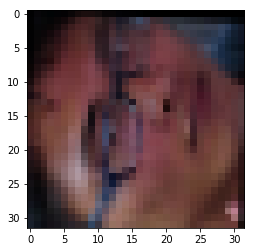

In [75]:
test_idx=11
print data['y_val'][test_idx]
det=getrotation_img(data['X_val'][test_idx, :],0)
plt.imshow(det.astype(np.uint8))

In [76]:

# create 720 rotation images
print data['y_val'][test_idx]
for i in xrange(720):
    if i==0:
        X_test_temp=np.reshape(getrotation_img(data['X_val'][test_idx, :],i), (-1, 32,32,3))
    else:
        temp=np.reshape(getrotation_img(data['X_val'][test_idx, :],i), (-1, 32,32,3))
        X_test_temp=np.concatenate((X_test_temp, temp), axis=0)


0


In [77]:
#[n.name for n in tf.get_default_graph().as_graph_def().node]

feature_net=tf.get_default_graph().get_tensor_by_name("SpatialTransformer/_transform/Reshape_5:0")
feature_net

<tf.Tensor 'SpatialTransformer/_transform/Reshape_5:0' shape=(?, 32, 32, ?) dtype=float32>

In [78]:
predctions_whimh,theta,ROI = sess.run([tf_predictions,h_fc_loc2,feature_net], feed_dict={   
        x:X_test_temp,
        keep_prob:1,
    })

In [82]:
sum(predctions_whimh==0)/720.0

0.98333333333333328

In [83]:
h_trans.shape

TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(None)])

In [84]:
def getboundary(theta):
    four_angles=np.array([[1,1,1],[1,-1,1],[-1,-1,1],[-1,1,1]])
    theta=theta.reshape([2,3])
    WH=np.array([32,32])
    return (((theta.dot(four_angles.T)+1)/2).T*WH)

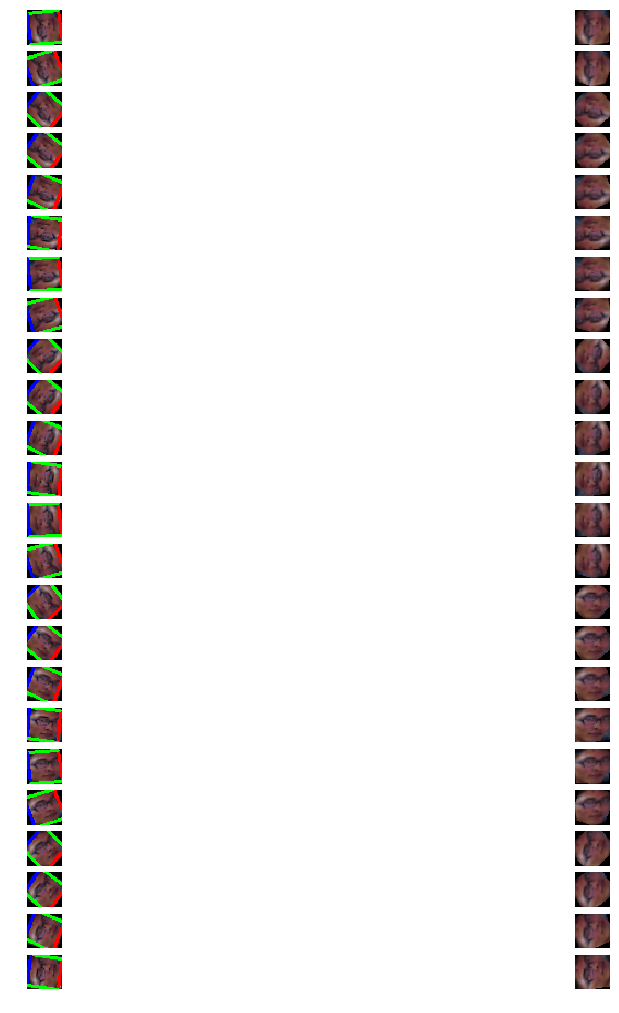

In [92]:
import cv2
width = 18
height = 18
plt.figure(figsize=(width, height))
count=1
for i in [15,30,45,60,75,90,105,120,135,150,165,180,195,210,225,240,255,270,285,300,315,330,345,360]:
    plt.subplot(24, 2, count)
    first_train_img = X_test_temp[i].copy()
    #first_train_img = cv2.cvtColor(first_train_img,cv2.COLOR_GRAY2RGB)
    fourangle=getboundary(theta[i])
    fourangle=fourangle.astype(int)
    cv2.line(first_train_img,tuple(fourangle[0].tolist()),tuple(fourangle[1].tolist()),(255,0,0),2)
    cv2.line(first_train_img,tuple(fourangle[1].tolist()),tuple(fourangle[2].tolist()),(0,255,0),2)
    cv2.line(first_train_img,tuple(fourangle[2].tolist()),tuple(fourangle[3].tolist()),(0,0,255),2)
    cv2.line(first_train_img,tuple(fourangle[3].tolist()),tuple(fourangle[0].tolist()),(0,255,0),2)
    plt.imshow(first_train_img.astype(np.uint8))
    plt.axis('off')
    count+=1
    plt.subplot(24, 2, count)
    first_train_img = ROI[i].astype(np.uint8)
    plt.imshow(first_train_img)
    plt.axis('off')
    count+=1
    
plt.show()

In [86]:
# add retangle to image and write it out
for i in xrange(720):
    first_train_img = X_test_temp[i].copy().astype(np.uint8)
    first_train_img = cv2.cvtColor(first_train_img,cv2.COLOR_BGR2RGB)
    #first_train_img = cv2.cvtColor(first_train_img,cv2.COLOR_GRAY2RGB)
    fourangle=getboundary(theta[i])
    fourangle=fourangle.astype(int)
    #cv2.rectangle(first_train_img, tuple(twoangle[0].tolist()), tuple(twoangle[1].tolist()), (0, 1,0),2)
    cv2.line(first_train_img,tuple(fourangle[0].tolist()),tuple(fourangle[1].tolist()),(255,0,0),2)
    cv2.line(first_train_img,tuple(fourangle[1].tolist()),tuple(fourangle[2].tolist()),(0,255,0),2)
    cv2.line(first_train_img,tuple(fourangle[2].tolist()),tuple(fourangle[3].tolist()),(0,0,255),2)
    cv2.line(first_train_img,tuple(fourangle[3].tolist()),tuple(fourangle[0].tolist()),(0,255,0),2)
    cv2.imwrite('face_rotation/'+str(i).zfill(4)+'.jpg',first_train_img)

# [sec2-1] finaelly let's play with cnn without stn

In [1]:
import tensorflow as tf
from spatial_transformer import transformer
import numpy as np
frames=np.load("rotated_x.npy")
y_train=np.load("rotated_y.npy").astype(int)


In [2]:
arr = np.arange(len(frames))
np.random.shuffle(arr)
x_train=frames[arr]
y_train=y_train[arr]
data={
  'X_train': x_train[:int(len(x_train)*0.8)],
  'y_train': y_train[:int(len(x_train)*0.8)],
  'X_val': x_train[int(len(x_train)*0.8):],
  'y_val': y_train[int(len(x_train)*0.8):],
  'X_val_frame' : frames[int(len(x_train)*0.8):],
}
print "there are "+ str(data['X_train'].shape[0]) + " images in training set"
print "there are "+ str(data['X_val'].shape[0]) + " images in testing set"

there are 32126 images in training set
there are 8032 images in testing set


In [3]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.0001)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.01, shape=shape)
  return tf.Variable(initial)


In [4]:
# %% We can add dropout for regularizing and to reduce overfitting like so:
regular_lambda = tf.placeholder(tf.float32)
learning_rate = tf.placeholder(tf.float32)
keep_prob = tf.placeholder(tf.float32)


# %% Graph representation of our network

# %% Placeholders for 40x40 resolution
y_tf = tf.placeholder(tf.int32, shape=[None,],name='ground_truth')
y_tf_2=tf.one_hot(y_tf,5)

#reshape X
x_tensor = tf.placeholder(tf.float32, [None, 32,32,3])


#conv_1
filter_size = 3
n_filters_1 = 16
W_conv1 = weight_variable([filter_size, filter_size, 3, n_filters_1])
b_conv1 = bias_variable([n_filters_1])
h_conv1 = tf.nn.relu(
    tf.nn.conv2d(input=x_tensor,
                 filter=W_conv1,
                 strides=[1, 2, 2, 1],
                 padding='SAME') +
    b_conv1)

flat_h_shape=int(h_conv1.shape[1]*h_conv1.shape[2]*h_conv1.shape[3])
h_conv1_flat = tf.reshape(h_conv1, [-1, flat_h_shape])

#FC
n_fc = 512
W_fc1 = weight_variable([flat_h_shape, n_fc])
b_fc1 = bias_variable([n_fc])
h_fc1 = tf.nn.relu(tf.matmul(h_conv1_flat, W_fc1) + b_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#softmax
W_fc2 = weight_variable([n_fc, 5])
b_fc2 = bias_variable([5])
y_logits = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# regu_cnn = tf.nn.l2_loss(W_fc1)+tf.nn.l2_loss(W_fc2)+tf.nn.l2_loss(b_fc1)+tf.nn.l2_loss(b_fc2)+\
#        tf.nn.l2_loss(W_conv2)+tf.nn.l2_loss(W_conv1)+tf.nn.l2_loss(b_conv2)+tf.nn.l2_loss(b_conv1)
    
regu_cnn = tf.nn.l2_loss(W_fc1)+tf.nn.l2_loss(W_fc2)+tf.nn.l2_loss(b_fc1)+tf.nn.l2_loss(b_fc2)+\
    tf.nn.l2_loss(W_conv1)+tf.nn.l2_loss(b_conv1)
regu=regu_cnn


global_step = tf.Variable(0, trainable=False)
learning_rate_decay = tf.train.exponential_decay(learning_rate, global_step,
                                           1000, 0.96, staircase=True)

# %% Define loss/eval/training functions
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=y_logits, labels=y_tf_2))

with tf.name_scope('loss'):
    #carefully deal overfitting
    loss=cross_entropy+regular_lambda*regu
with tf.name_scope('slover'):
    global_step = tf.Variable(0, trainable=False)
    learning_rate_decay = tf.train.exponential_decay(learning_rate, global_step,
                                               3000, 0.96, staircase=True)
    opt = tf.train.AdamOptimizer(learning_rate=learning_rate_decay)
    train_step = opt.minimize(loss)



#grads = opt.compute_gradients(cross_entropy, [b_fc_loc2])

# %% Monitor accuracy
tf_predictions=tf.argmax(y_logits, 1)
ground_truth=tf.argmax(y_tf_2, 1)
correct_prediction = tf.equal(tf.argmax(y_logits, 1), ground_truth)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

#MHaccuracy
idxsMH = tf.where(tf.equal(ground_truth, 0))
correct_predictionMH = tf.equal(tf.argmax(tf.gather(y_logits,idxsMH),2), tf.argmax(tf.gather(y_tf_2,idxsMH),2))
accuracyMH = tf.reduce_mean(tf.cast(correct_predictionMH, tf.float32))
#NMaccuracy
idxsNM = tf.where(tf.equal(ground_truth, 1))
correct_predictionNM = tf.equal(tf.argmax(tf.gather(y_logits,idxsNM),2), tf.argmax(tf.gather(y_tf_2,idxsNM),2))
accuracyNM = tf.reduce_mean(tf.cast(correct_predictionNM, tf.float32))
#NHaccuracy
idxsNH = tf.where(tf.equal(ground_truth, 2))
correct_predictionNH = tf.equal(tf.argmax(tf.gather(y_logits,idxsNH),2), tf.argmax(tf.gather(y_tf_2,idxsNH),2))
accuracyNH = tf.reduce_mean(tf.cast(correct_predictionNH, tf.float32))
#MEaccuracy
idxsME = tf.where(tf.equal(ground_truth, 3))
correct_predictionME = tf.equal(tf.argmax(tf.gather(y_logits,idxsME),2), tf.argmax(tf.gather(y_tf_2,idxsME),2))
accuracyME = tf.reduce_mean(tf.cast(correct_predictionME, tf.float32))
#Soaccuracy
idxsSO = tf.where(tf.equal(ground_truth, 4))
correct_predictionSO = tf.equal(tf.argmax(tf.gather(y_logits,idxsSO),2), tf.argmax(tf.gather(y_tf_2,idxsSO),2))
accuracySO = tf.reduce_mean(tf.cast(correct_predictionSO, tf.float32))

tf.summary.scalar('accuracy', accuracy)
tf.summary.scalar('accuracyMH', accuracyMH)
tf.summary.scalar('accuracyNM', accuracyNM)
tf.summary.scalar('accuracyNH', accuracyNH)
tf.summary.scalar('accuracyME', accuracyME)
tf.summary.scalar('accuracySO', accuracySO)
#this variable means records all records
merged = tf.summary.merge_all()

In [5]:

# %% We now create a new session to actually perform the initialization the
# variables:
sess = tf.Session()
sess.run(tf.global_variables_initializer())


In [6]:
train_writer = tf.summary.FileWriter('/tmp/cnn_face_nostn/train',sess.graph)
test_writer = tf.summary.FileWriter('/tmp/cnn_face_nostn/test')
count=0

In [7]:
# %% We'll now train in minibatches and report accuracy, loss:
iter_per_epoch = 4000
n_epochs = 100
train_size = 32126  
regular_lambda_=1e-4
indices = np.linspace(0, train_size-1, iter_per_epoch)
indices = indices.astype('int')

for epoch_i in range(n_epochs):
    for iter_i in range(iter_per_epoch - 1):
        batch_xs = data['X_train'][indices[iter_i]:indices[iter_i+1]]
        batch_ys = data['y_train'][indices[iter_i]:indices[iter_i+1]]
        
        if iter_i % 500 == 0:
            summary,loss,accuracy_ = sess.run([merged,cross_entropy,accuracy],
                            feed_dict={
                                x_tensor: batch_xs,
                                y_tf: batch_ys,
                                regular_lambda: regular_lambda_,
                                keep_prob:1
                            })

            train_writer.add_summary(summary, count)
            
            vali_xs = data['X_val']
            vali_ys = data['y_val']
            summary,loss_val,accuracy_val = sess.run([merged,cross_entropy,accuracy],
                            feed_dict={
                                x_tensor: vali_xs,
                                y_tf: vali_ys,
                                regular_lambda: regular_lambda_,
                                keep_prob:1
                            })
            test_writer.add_summary(summary, count)

            print('training acc: ' + str(accuracy_) +' testing acc :' +str(accuracy_val)+ 
                  ' /training Loss: ' + str(loss) +' testing loss :' +str(loss_val))
            count+=1



        sess.run(train_step, feed_dict={
            x_tensor: batch_xs, y_tf: batch_ys, learning_rate:0.0001, keep_prob:0.5, regular_lambda:regular_lambda_})
        



training acc: 0.0 testing acc :0.164592 /training Loss: 1.60944 testing loss :1.60944
training acc: 0.625 testing acc :0.452689 /training Loss: 1.41589 testing loss :1.47447
training acc: 0.5 testing acc :0.479457 /training Loss: 1.32679 testing loss :1.35783
training acc: 0.75 testing acc :0.565862 /training Loss: 1.0171 testing loss :1.21089
training acc: 0.625 testing acc :0.577565 /training Loss: 1.03679 testing loss :1.1161
training acc: 0.75 testing acc :0.589143 /training Loss: 0.813615 testing loss :1.0782
training acc: 0.875 testing acc :0.619273 /training Loss: 0.719202 testing loss :1.04641
training acc: 1.0 testing acc :0.616907 /training Loss: 0.594977 testing loss :1.02378
training acc: 0.625 testing acc :0.609437 /training Loss: 0.948195 testing loss :1.09266
training acc: 0.875 testing acc :0.658367 /training Loss: 0.728099 testing loss :0.911116
training acc: 0.75 testing acc :0.665588 /training Loss: 0.805494 testing loss :0.882019
training acc: 0.75 testing acc :0.64

KeyboardInterrupt: 